# PDI

This notebook introduces our method and illustrates some of the exploratory work motivating our analysis. 

The notebook also replicates some of the figures in [our paper](https://arxiv.org/abs/1903.05041) using the included datasets and pretrained tagger models. The code is somewhat dense since the main purpose was to create figures, but the relevant methods are discussed in sections `4.1` and `4.2`.

In [1]:
%load_ext autoreload

%autoreload 2
import numpy as np
import dynet as dy
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from collections import defaultdict

%matplotlib inline

import seaborn as sns
sns.set()

## SETUP

`languages.csv` contains our 24 languages, coresponding short names, and categories of affixation and synthesis.

**To run this** you need to unpack the files in `datasets` and `models`

In [2]:
languages = {}
with open('datasets/ud-2.3/languages.csv', 'r') as f:
    for line in f:
        ln, name, _, _ = line.split(',')
        languages[ln.strip()] = name.strip()

#pretrained models are included for en, he, ar, cp, zh, tr
languages = {ln : name for ln, name in languages.items() if ln in ['en', 'he', 'ar', 'cop', 'zh', 'tr']}
languages

{'ar': 'Arabic',
 'cop': 'Coptic',
 'en': 'English',
 'he': 'Hebrew',
 'tr': 'Turkish',
 'zh': 'Chinese'}

Here, we load the pretrained models and gather part of speech lists for each language. The model dimensionality is set to `64/64` (a `128` dimensional BiLSTM), but you can train one of our **asymmetric** models and load them as well by changing the constants. 

In [3]:
from model import ProcessedDataset, Instance
from analysis_utils import get_all_pos, get_best_model_name
from analysis import get_single_activation
from infer import WrappedTagger

FWD = 64
BWD = 64
FWD_BWD_THRESH = FWD
model_base_path = 'models/{}'

ln_to_pos = {}
ln_to_activations = {}
for ln in languages:
    word_to_pos = {}
    dataset_path = 'datasets/ud-2.3/{}_ud23.pkl'.format(ln)
    dataset = ProcessedDataset(dataset_path)
    pos_to_words = get_all_pos(dataset, dataset.training_instances, 8, 0.60)
    
    for tag, words in pos_to_words.items():
        for word in words:
            word_to_pos[word] = tag
    ln_to_pos[ln] = word_to_pos

    model = WrappedTagger(dataset_path, 2, (FWD, BWD), 256, word_level_dim = 128)
    model.load_weights(get_best_model_name(model_base_path.format(ln)))

    ln_to_activations[ln] = {word : get_single_activation(model, word) for word in word_to_pos.keys()}

INFO:root:char bilstm: char_embedding_dim 256 hidden (64, 64)
INFO:root:word bilstm: input_dim 128 word_level_dim 128


using asym rnn, f = 64, b = 64
models/ar
Using legacy loading


INFO:root:char bilstm: char_embedding_dim 256 hidden (64, 64)
INFO:root:word bilstm: input_dim 128 word_level_dim 128


using asym rnn, f = 64, b = 64
models/cop
Using standard loading


INFO:root:char bilstm: char_embedding_dim 256 hidden (64, 64)
INFO:root:word bilstm: input_dim 128 word_level_dim 128


using asym rnn, f = 64, b = 64
models/en
Using legacy loading


INFO:root:char bilstm: char_embedding_dim 256 hidden (64, 64)
INFO:root:word bilstm: input_dim 128 word_level_dim 128


using asym rnn, f = 64, b = 64
models/he
Using legacy loading


INFO:root:char bilstm: char_embedding_dim 256 hidden (64, 64)
INFO:root:word bilstm: input_dim 128 word_level_dim 128


using asym rnn, f = 64, b = 64
models/tr
Using legacy loading


INFO:root:char bilstm: char_embedding_dim 256 hidden (64, 64)
INFO:root:word bilstm: input_dim 128 word_level_dim 128


using asym rnn, f = 64, b = 64
models/zh
Using legacy loading


## Exploratory Plots

Each of the 128 points along the x axis represents a neuron, and the value on the y axis is our metric. 

ar
Top units: [ 73   3  44  49 125  61  27  46  25   7]


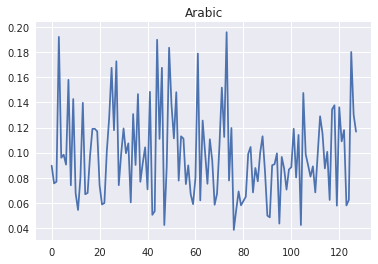

cop
Top units: [ 25  68  14  18 125  23  15  84  27  38]


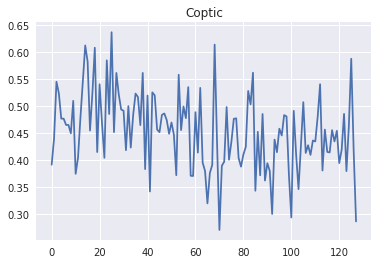

en
Top units: [ 96  69 114  76  95  73 127 123  98 105]


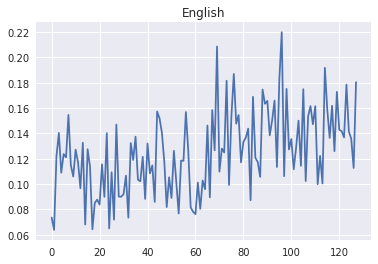

he
Top units: [ 6 32 58 31 56 46 60 39  7 67]


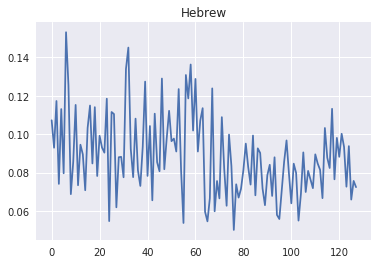

tr
Top units: [10 42 40 41 89  1 39 48 77  2]


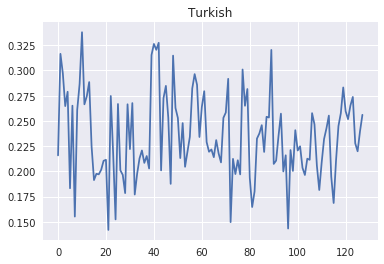

zh
Top units: [104 127  38   1  93 100 114 110 121 105]


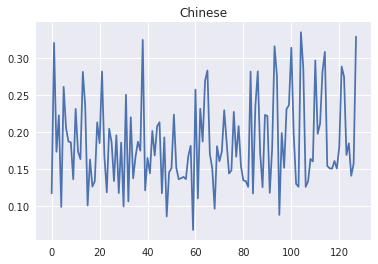

In [4]:
from analysis import pmi_macro_abs_avg, pmi_max_diff, kl_max_diff, kl_final_acts

for ln in languages:
    print(ln)
    word_to_pos = ln_to_pos[ln]
    activations = ln_to_activations[ln]
    
    kls = pmi_macro_abs_avg(activations, word_to_pos, all_poss=None)
#     kls = pmi_max_diff(activations, word_to_pos, all_poss=None)
#     kls = pmi_max_diff(activations, word_to_pos)

    
    top = np.argsort(abs(kls))[-10:][::-1]
    
    print("Top units: {}".format(top))
    
    plt.plot(range(len(kls)), kls)
    plt.title(languages[ln])
    plt.show()

## Observations

Notice that these languages seem to vary quite a bit in terms of "spikiness" and magnitude!

Also note that in several cases (Hebrew, English), the first 64 neurons seem to behave very differently when compared to the last 64 neurons. This is caused by the forward/backward split of the 128 dimensional BiLSTM!

We gather summary metrics about these qualitative observations in the cells below. Note that this uses the macro absolute average PDI metric (denoted $b_{avg|\cdot|}$ in the paper).

ar
Sum of kls: 12.6080
% mass of forward units: 52.69
head@50  ix: 46
forward units in head: 27.0
% forward units in head: 58.70


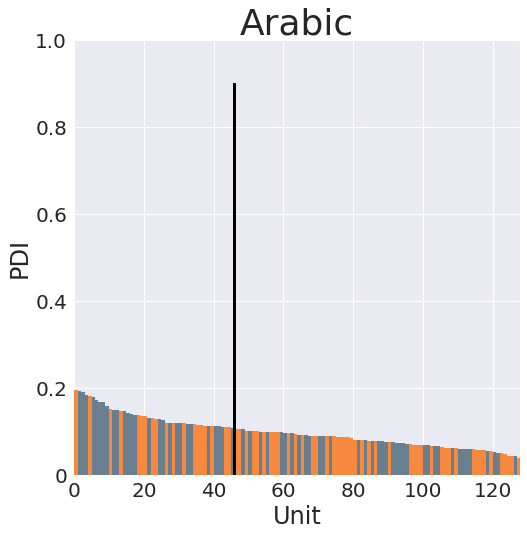

cop
Sum of kls: 58.0808
% mass of forward units: 52.94
head@50  ix: 56
forward units in head: 40.0
% forward units in head: 71.43


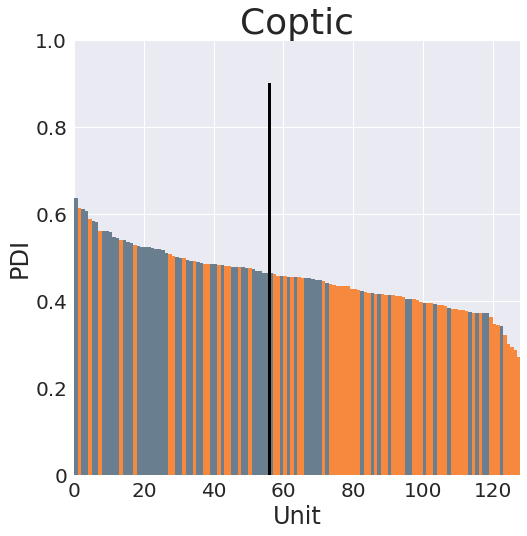

en
Sum of kls: 15.9592
% mass of forward units: 42.95
head@50  ix: 50
forward units in head: 10.0
% forward units in head: 20.00


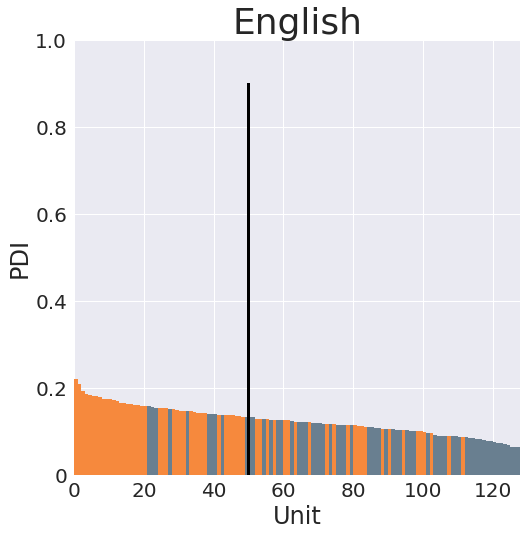

he
Sum of kls: 11.3727
% mass of forward units: 55.37
head@50  ix: 51
forward units in head: 38.0
% forward units in head: 74.51


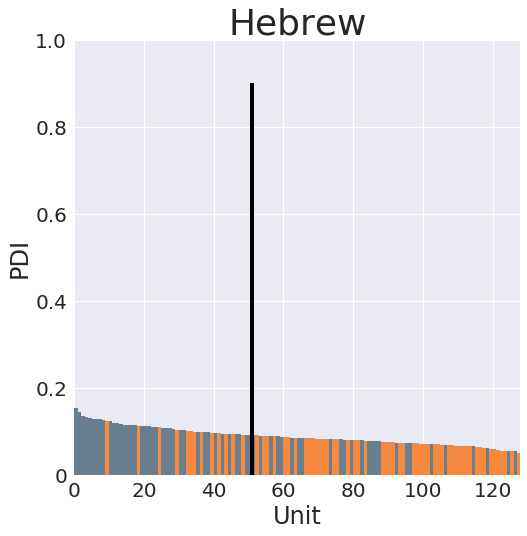

tr
Sum of kls: 30.0681
% mass of forward units: 51.46
head@50  ix: 54
forward units in head: 31.0
% forward units in head: 57.41


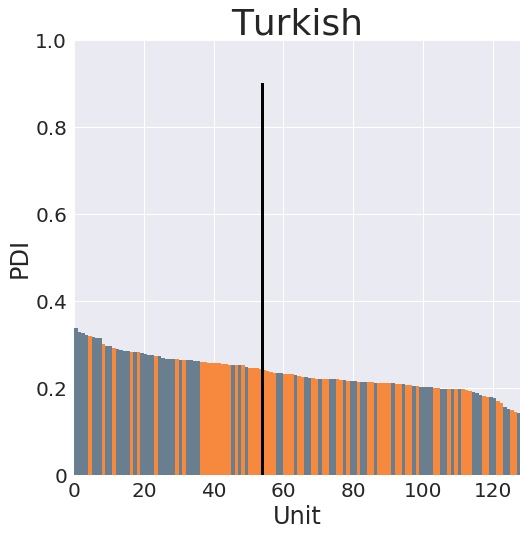

zh
Sum of kls: 23.7589
% mass of forward units: 47.18
head@50  ix: 47
forward units in head: 20.0
% forward units in head: 42.55


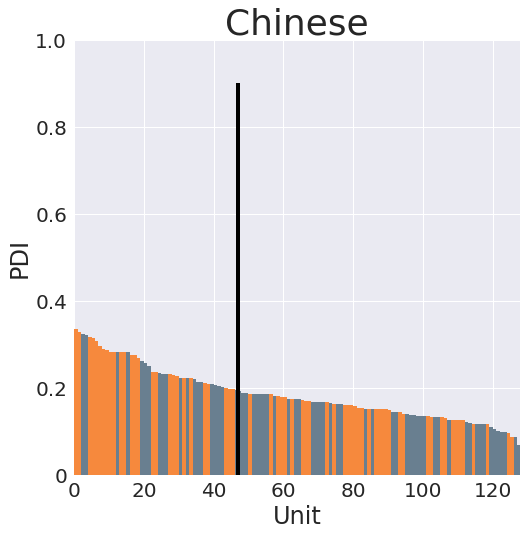

In [5]:
from analysis import get_head

metrics = defaultdict(dict)
for ln in sorted(languages.keys()):
    print(ln)
    activations = ln_to_activations[ln]
    wtp = ln_to_pos[ln]
    kls = pmi_macro_abs_avg(activations, wtp, all_poss=None)
#     kls = pmi_max_diff(activations, wtp, all_poss=None)
#     kls = pmi_max_diff(activations, wtp)
    #kls = kl_max_diff(activations, wtp)
    #kls = kl_final_acts(activations, wtp)
        
    #process kls, mark forward and backward units
    sum_of_kls = sum(d for d in abs(kls))
    metrics[ln]['sum_of_kls'] = sum_of_kls
    print("Sum of kls: {:.4f}".format(sum_of_kls))
    fwd_mass = 100 * sum(d for d in abs(kls)[:FWD_BWD_THRESH]) / sum_of_kls
    metrics[ln]['fwd_mass'] = fwd_mass
    print("% mass of forward units: {:.2f}".format(fwd_mass))
    ixs = np.argsort(abs(kls))[::-1]
    kls = abs(kls[ixs])
    
    #friendly, non red blue
    colors = ['#697f90' if ix < FWD_BWD_THRESH else '#f6893d' for ix in ixs]
    #hatches = ['x' if ix < FWD_BWD_THRES else '' for ix in ixs]
    
    #headiness
    head_50 = get_head(kls, 0.5)
    metrics[ln]['head_50'] = head_50
    print("head@50  ix: {}".format(head_50))
    forwards = np.count_nonzero(ixs[:head_50] < FWD_BWD_THRESH) * 1.0
    metrics[ln]['forward_in_head'] = forwards
    pct = 100 * forwards / head_50
    metrics[ln]['pct'] = pct
    print("forward units in head: {}".format(forwards))
    print("% forward units in head: {:.2f}".format(pct))
    
    #ploting, etc
    plt.figure(figsize = (8, 8))
    plt.bar(list(range(len(kls))) + [head_50 - 0.5],
            list(kls) + [0.9],
            width = 1.0, color = list(colors) + ['#000000'],
            align='edge')
            #hatch=hatches + ['']
    a = plt.gca()
    a.set_xticklabels([0,20,40,60,80,100,120], fontdict={'fontsize':20})
    a.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0], fontdict={'fontsize':20})
    a.set_xlabel('Unit', fontdict={'fontsize':24})
    a.set_ylabel('PDI', fontdict={'fontsize':24})
    a.set_xlim(0, 128)
    a.set_ylim(0, 1.0)
    plt.title(languages[ln], fontdict={'fontsize':36})
    plt.show()
    print("=========================")
    #blue is forward, orange is backward

### See our [paper](https://arxiv.org/abs/1903.05041) for more analysis!